In [26]:
import hashlib
import os
import numpy as np
import datetime
import csv
import time
from PIL import Image, ImageDraw, ImageFont
import json

def save_game_data(unique_id, metadata, game_states):
    folder_path = f'game_states/{unique_id}/'
    os.makedirs(folder_path, exist_ok=True)

    # Save metadata
    with open(f"{folder_path}metadata.json", "w") as f:
        json.dump(metadata, f)

    # Save game state history
    with open(f"{folder_path}game_state.csv", "w", newline='') as f:
        writer = csv.DictWriter(f, fieldnames=game_states[0].keys())
        writer.writeheader()
        for state in game_states:
            writer.writerow(state)
            
def simple_turn_with_state(guess_board, board, player_lives, turn, player):
    valid_targets = np.argwhere(guess_board is None)
    if valid_targets.size == 0:
        game_state = {
        'Turn': turn,
        'Player': player,
        'Shot_Row': None,
        'Shot_Col': None,
        'Result': 'Surrender',
        'Player_Lives': player_lives}  
        return guess_board, board, player_lives, game_state
    else:
        shot_idx = np.random.randint(valid_targets.shape[0])
        shot_actual = tuple(valid_targets[shot_idx])
        check_hit = board[shot_actual]
        
        if check_hit == 'F':  # Hit
            guess_board[shot_actual] = board[shot_actual] = result = 'H'
            player_lives -= 1
        else: # Miss
            guess_board[shot_actual] = result = 'M'

        game_state = {
            'Turn': turn,
            'Player': player,
            'Shot_Row': shot_actual[0],
            'Shot_Col': shot_actual[1],
            'Result': result,
            'Player_Lives': player_lives
        }
        
        return guess_board, board, player_lives, game_state

def simple_game(unique_id):    
    board_size = 10
    fleet_size = 5
    board1, board2 = np.empty((board_size, board_size), dtype=str), np.empty((board_size, board_size), dtype=str)
    rng = np.random.default_rng()
    tiles = board_size * board_size
    fleet_positions1 = rng.choice(tiles, size=fleet_size, replace=False)
    fleet_positions2 = rng.choice(tiles, size=fleet_size, replace=False)
    fleet1_actual = np.unravel_index(fleet_positions1, (board_size, board_size))
    fleet2_actual = np.unravel_index(fleet_positions2, (board_size, board_size))
  
    board1[fleet1_actual] = 'F'
    board2[fleet2_actual] = 'F'
    guess_board1, guess_board2 = np.empty((board_size, board_size), dtype=str), np.empty((board_size, board_size), dtype=str)
    player1_lives, player2_lives = fleet_size, fleet_size
    game_states = []
    
    turn, shots1, shots2, hits1, hits2 = 0, 0, 0, 0, 0
    while (player1_lives > 0 or player2_lives > 0):
        turn += 1
        guess_board1, board2, player2_lives, game_state1 = simple_turn_with_state(guess_board1, board2, player2_lives, turn, 1)
        shots1 += 1
        hits1 += game_state1['Result'] == 'H'
        game_states.append(game_state1)
        
        guess_board2, board1, player1_lives, game_state2 = simple_turn_with_state(guess_board2, board1, player1_lives, turn, 2)
        shots2 += 1
        hits2 += game_state2['Result'] == 'H'
        game_states.append(game_state2)
    
    winner = (1 if player1_lives > 0 else 2)
    accuracy1, accuracy2 = (hits1 / shots1) * 100, (hits2 / shots2) * 100
    metadata = {
        'Total_Turns': turn,
        'Winner': winner,
        'Player1_Accuracy': accuracy1,
        'Player2_Accuracy': accuracy2
    }
    
    save_game_data(unique_id, metadata, game_states)
    
    return metadata, np.copy(board1), np.copy(board2)

# Re-adding the generate_unique_id function
def generate_unique_id():
    unique_str = str(np.random.random()) + datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
    unique_id = hashlib.md5(unique_str.encode()).hexdigest()
    return unique_id[:16]

def draw_board(draw, board, x_offset, y_offset, cell_size, board_size):
    for row in range(board_size):
        for col in range(board_size):
            x1, y1 = x_offset + col * cell_size, y_offset + row * cell_size
            x2, y2 = x1 + cell_size, y1 + cell_size
            color = "white"
            if board[row, col] == 'E':
                color = "white"  # Empty
            elif board[row, col] == 'M':
                color = "blue"  # Miss
            elif board[row, col] == 'H':
                color = "red"  # Hit
            elif board[row, col] == 'F':
                color = "green"  # Fleet
            elif board[row, col] == 'S':
                color = "black"  # Separator
            draw.rectangle([x1, y1, x2, y2], fill=color)
            
# Further Updated Function to render game state to image with extra black lines
def render_game_state_to_image(game_state, initial_board1, initial_board2, board_size=10, cell_size=20):
    board_size += 1  # Adding extra row and column for the separator
    img_size = board_size * cell_size * 2  # accommodate both boards for each player
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)
    
    board1 = np.empty((board_size, board_size), dtype=str)
    board1[:-1, :-1] = initial_board1  # Copying initial_board1 to board1
    board2 = np.empty((board_size, board_size), dtype=str)
    board2[:-1, :-1] = initial_board2  # Copying initial_board2 to board2
    guess_board1 = np.empty((board_size, board_size), dtype=str)
    guess_board2 = np.empty((board_size, board_size), dtype=str)
    
    # Fill last row and column with separators (4)
    board1[-1, :] = 4
    board1[:, -1] = 4
    board2[-1, :] = 4
    board2[:, -1] = 4
    guess_board1[-1, :] = 4
    guess_board1[:, -1] = 4
    guess_board2[-1, :] = 4
    guess_board2[:, -1] = 4

    for state in game_state:
        player = int(state['Player'])
        row = int(state['Shot_Row'])
        col = int(state['Shot_Col'])
        result = state['Result']

        if player == 1:
            guess_board2[row, col] = result  
            if result == 'H':
                board2[row, col] = 'H'
        else:
            guess_board1[row, col] = result  
            if result == 'H':
                board1[row, col] = 'H'

    draw_board(draw, board1, 0, 0, cell_size, board_size)
    draw_board(draw, guess_board1, board_size * cell_size, 0, cell_size, board_size)
    draw_board(draw, board2, 0, board_size * cell_size, cell_size, board_size)
    draw_board(draw, guess_board2, board_size * cell_size, board_size * cell_size, cell_size, board_size)

    return img

def save_game_states_as_gif(game_states, initial_board1, initial_board2, output_path):
    frames = []
    accumulated_states = []
    for i in range(0, len(game_states), 2):
        accumulated_states.extend(game_states[i:i+2])
        img = render_game_state_to_image(accumulated_states, initial_board1, initial_board2)
        frames.append(img)
    frames[0].save(output_path, save_all=True, append_images=frames[1:], loop=0, duration=500)
    
# Function to read game state from a CSV given a unique_id
def read_game_state_from_csv(unique_id):
    folder_path = os.path.join("game_states", unique_id)
    game_state_path = os.path.join(folder_path, 'game_state.csv')
    game_state = []
    try:
        with open(game_state_path, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                game_state.append(row)
    except FileNotFoundError:
        print(f"File not found: {game_state_path}")
    return game_state

def run_and_visualize_game():
    unique_id = generate_unique_id()
    metadata, initial_board1, initial_board2 = simple_game(unique_id)
    
    game_state = read_game_state_from_csv(unique_id)
    if game_state:
        output_gif_path = os.path.join("game_states", unique_id, 'game_animation.gif')
        save_game_states_as_gif(game_state, initial_board1, initial_board2, output_gif_path)
    else:
        print("Game state could not be loaded, skipping visualization.")

def enumerate_valid_positions(board_size, ship_length, wrap):
    valid_positions = []
    for row in range(board_size):
        for col in range(board_size):
            if wrap or (row + ship_length - 1 < board_size):
                valid_positions.append((row, col, 'down'))
            if wrap or (col + ship_length - 1 < board_size):
                valid_positions.append((row, col, 'right'))
    return valid_positions

def place_ship(board, start_row, start_col, direction, ship_length, wrap):
    board_size = board.shape[0]
    if direction == 'down': # down
        for i in range(ship_length):
            row = (start_row + i) % board_size if wrap else start_row + i
            board[row, start_col] = 'F'
    else: # right
        for i in range(ship_length):
            col = (start_col + i) % board_size if wrap else start_col + i
            board[start_row, col] = 'F'

def place_real_ships(board, ship_lengths, wrap):
    rng = np.random.default_rng()
    board_size = board.shape[0]
    
    for ship_length in ship_lengths:
        valid_positions = enumerate_valid_positions(board_size, ship_length, wrap)
        rng.shuffle(valid_positions)  # Shuffle the list first
        for start_row, start_col, direction in valid_positions:
            if direction == 'down':
                slice_to_check = board[start_row: start_row + ship_length, start_col]
            else:
                slice_to_check = board[start_row, start_col: start_col + ship_length]
            
            if all(x == 'E' for x in slice_to_check):
                place_ship(board, start_row, start_col, direction, ship_length, wrap)
                break  # Break out of the loop if ship is successfully placed
            
    return board

def accuracy(hits, shots):
    if shots == 0:
        return 0
    else:
        return np.round(np.divide(hits, shots) * 100, 2)

def real_ships_simple_game(unique_id, ship_lengths=[5, 4, 3, 3, 2], wrap=False):
        
    board_size = 10
    board1, board2 = np.full((board_size, board_size), 'E', dtype=str), np.full((board_size, board_size), 'E', dtype=str)
 
    # Place real ships on the boards
    board1 = place_real_ships(board1, ship_lengths, wrap)
    board2 = place_real_ships(board2, ship_lengths, wrap)
    print('Fleets placed')
    
    guess_board1, guess_board2 = np.full((board_size, board_size), 'E', dtype=str), np.full((board_size, board_size), 'Empty', dtype=str)
    # Lives are equal to the number of 'Fleet' tiles on the board, where (board == 'Fleet')
    player1_lives, player2_lives = np.sum(board1 == 'F'), np.sum(board2 == 'F')

    game_states = []
    
    turn, shots1, shots2, hits1, hits2 = 0, 0, 0, 0, 0
    while (player1_lives > 0 or player2_lives > 0):
        turn += 1
        if turn>250:
            # print("Turn limit reached, stopping game.")
            break
        guess_board1, board2, player2_lives, game_state1 = simple_turn_with_state(guess_board1, board2, player2_lives, turn, 1)
        shots1 += 1
        hits1 += game_state1['Result'] == 'H'
        game_states.append(game_state1)
        
        guess_board2, board1, player1_lives, game_state2 = simple_turn_with_state(guess_board2, board1, player1_lives, turn, 2)
        shots2 += 1
        hits2 += game_state2['Result'] == 'H'
        game_states.append(game_state2)
    
    winner = 1 if player1_lives > 0 else 2
    
    accuracy1, accuracy2 = accuracy(hits1, shots1), accuracy(hits2, shots2)
    metadata = {
        'Total_Turns': turn,
        'Winner': winner,
        'Player1_Accuracy': accuracy1,
        'Player2_Accuracy': accuracy2
    }
    
    save_game_data(unique_id, metadata, game_states)
    return metadata, np.copy(board1), np.copy(board2)

def generate_one_game():
    unique_id = generate_unique_id()
    metadata, initial_board1, initial_board2 = real_ships_simple_game(unique_id)
    print("Metadata:", metadata)

    # Now visualize it
    game_state = read_game_state_from_csv(unique_id)
    if game_state:
        output_gif_path = os.path.join("game_states", unique_id, 'game_animation.gif')
        save_game_states_as_gif(game_state, initial_board1, initial_board2, output_gif_path)
    else:
        print("Game state could not be loaded, skipping visualization.")
    return unique_id

generate_one_game()

Fleets placed
Metadata: {'Total_Turns': 251, 'Winner': 1, 'Player1_Accuracy': 0.0, 'Player2_Accuracy': 0.0}


ValueError: invalid literal for int() with base 10: ''

In [34]:
from joblib import Parallel, delayed

def generate_n_games(n, workers=1):
    game_ids = Parallel(n_jobs=workers)(delayed(generate_one_game)() for _ in range(n))
    return game_ids

generate_n_games(10, workers=-1)

ZeroDivisionError: division by zero

In [5]:
###Imports###
import matplotlib.pyplot as plt
import random
import statistics
import math
from scipy.stats import t
from IPython.display import clear_output
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math

# How many board layouts are possible in the simplest game?
def calculate_simple_combinations(board_len, ships):
    tiles = board_len ** 2
    combinations = math.comb(tiles, ships)
    return combinations

# Convert a linear index ship position to row and column
def convert_ship_index(index, board_len):
    row = math.floor(index / board_len)
    col = index % board_len
    return [row, col]

# Simple game turn-taking
def simple_turn(guess_board, board, player_lives):
    # Player can only guess where there is no ship or previous shot
    valid_targets = np.where(guess_board==0)
 
    #Convert the valid_targets to a 1D ordered array for random selection
    valid_targets_actual = np.ravel_multi_index(valid_targets, np.shape(guess_board))
    #print('valid targets', valid_targets_actual)

    # Initialize a numpy Generator object
    rng = np.random.default_rng()

    # Take a shot
    shot = rng.choice(valid_targets_actual, size=1, shuffle=False)
    #print('shot', shot)

    shot_actual = np.unravel_index(shot, np.shape(guess_board))
    #print('shot_actual', shot_actual)
    
    # Other player responds to guess
    check_hit = board[shot_actual]
    #print('check hit', check_hit)
    
    match check_hit:

        case 0:
            #print("Player missed at", shot_actual)
            guess_board[shot_actual] = 2
            board[shot_actual] = 2

        case 1:
            #print("Player sunk a ship at", shot_actual)
            guess_board[shot_actual] = 4
            board[shot_actual] = 4
            player_lives -= 1
    
    return guess_board, board, player_lives

# Single board plotting function
def plot_board(ax, board, cmap, norm, title):

    # Plot the basic board with colored squares
    ax.imshow(board, cmap=cmap, norm=norm)

    # Set the title of the plot
    ax.set_title(title)

    # Infer size of board
    board_size = board.shape[0]

    # Create a list of capital letters to use for vertical (row) labels
    row_labels = [chr(i) for i in range(65, 65 + board_size)]

    # Create a list of integers to use for horizontal (column) labels
    col_labels = [i for i in range(1, board_size + 1)]

    # Add a grid to the plot
    ax.grid(which='major', axis='both', linestyle='-', color='white', linewidth=2)
    ax.set_xticks(np.arange(-0.5, board_size-1, 1))
    ax.set_yticks(np.arange(-0.5, board_size-1, 1))

    # Label rows with letters and columns with numbers
    ax.set_yticklabels(row_labels)
    ax.set_xticklabels(col_labels)
    
    return ax

# Function to plot all 4 boards together
def plot_all_boards(board1, board2, guess_board1, guess_board2):

    #Fixed colormap
    cmap = colors.ListedColormap(['lightblue', 'green', 'yellow', 'red', 'black'])

    #0.5-off gridlines to make filled squares plot
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    #Explain the color of each cell
    legend = ['Empty', 'Ship', 'Miss', 'Hit', 'Sunk']

    # On-integer indexes for ticks
    tick_idx = np.arange(len(legend))

    # Create the figure and axs objects
    fig, axs = plt.subplots(2, 2)

    # Plot all four boards
    axs[0, 0] = plot_board(axs[0, 0], guess_board1, cmap, norm, "Player 1's Guess")
    axs[0, 1] = plot_board(axs[0, 1], guess_board2, cmap, norm, "Player 2's Guess")
    axs[1, 0] = plot_board(axs[1, 0], board1, cmap, norm, "Player 1's Fleet")
    axs[1, 1] = plot_board(axs[1, 1], board2, cmap, norm, "Player 2's Fleet")

    # Create colored dummy rectangles for legend
    handles = [plt.Rectangle((0, 0), 0, 0, color=cmap(i), label=legend[i]) for i in tick_idx]

    # Show the legend in the center of all 4 subplots
    fig.legend(handles=handles, loc='center')

    plt.tight_layout()
    plt.show()

    return fig, axs

### Simplest game - n single-space ships hidden on an m by m grid ###
def simple_game():
    board_size = 10
    fleet = ['Battleship', 'Cruiser', 'Destroyer', 'Submarine', 'Patrol Boat']
    fleet_shapes = [1, 1, 1, 1, 1]
    fleet_size = len(fleet)

    #Print Fleet info
    print('Fleet:', fleet)
    print('There are ', fleet_size, 'ships in the fleet,')
    print('of  lengths', fleet_shapes, '.')
    print('The board is a square with length', board_size, '.')

    #How many boards are possible?
    combos = calculate_simple_combinations(board_size, fleet_size)
    print('In this simple game of Battleship, each player has', f"{combos:,}", 'possible boards.')
    # Initialize both players' boards
    board1 = np.zeros((board_size, board_size))
    board2 = np.zeros((board_size, board_size))

    # Generate a random starting position for each player's fleet

    # Initialize a numpy Generator object
    rng = np.random.default_rng()

    # How many tiles are in each board?
    tiles = board_size * board_size

    #Generate fleet positions from all possible tiles for each board
    fleet_positions1 = rng.choice(tiles, size=fleet_size, replace=False, shuffle=False)
    fleet_positions2 = rng.choice(tiles, size=fleet_size, replace=False, shuffle=False)

    # Convert fleet positions to a 2D array of rows and columns
    fleet1_actual = np.unravel_index(fleet_positions1, (board_size, board_size))
    fleet2_actual = np.unravel_index(fleet_positions2, (board_size, board_size))

    # Place each player's fleet on their respective boards by setting the coordinates (matrix locations) where ships are placed to 1
    board1[fleet1_actual] = 1
    board2[fleet2_actual] = 1

    # Generate each player's 'view' of the opponent's board. Initially blank!
    guess_board1 = np.zeros((board_size, board_size))
    guess_board2 = np.zeros((board_size, board_size))

    # Get current date and time to make a unique filepath
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Create a directory to store the figure images from the timestamp
    output_dir = os.path.join("output", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    # Show the initial gamestate
    fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)
    plt.savefig(os.path.join(output_dir, "frame_0.png"))  # Save the initial figure as an image

    # Show the initial gamestate
    fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)
    plt.show()

    player1_live = fleet_size
    player2_live = fleet_size

    # Main loop
    frame = 0

    while player1_live > 0 and player2_live > 0:
        # Player 1's turn
        guess_board1, board2, player2_live = simple_turn(guess_board1, board2, player2_live)

        # Player 2's turn
        guess_board2, board1, player1_live = simple_turn(guess_board2, board1, player1_live)

        # Update board plot
        clear_output(wait=True)
        fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)

        # Frame number is incremented by 1 after each turn
        frame += 1

        # Make a string with the frame number to save the image
        fname = os.path.join(output_dir, "frame_" + str(frame) + ".png")

        #save the figure as an image
        fig.savefig(fname)

        plt.show()

    if player1_live == 0:
        print("Player 2 wins!")
    else:
        print("Player 1 wins!")
        
board_size = 10
fleet = ['Battleship', 'Cruiser', 'Destroyer', 'Submarine', 'Patrol Boat']
fleet_shapes = [1, 1, 1, 1, 1]
fleet_size = len(fleet)

#Print Fleet info
print('Fleet:', fleet)
print('There are ', fleet_size, 'ships in the fleet,')
print('of  lengths', fleet_shapes, '.')
print('The board is a square with length', board_size, '.')

#How many boards are possible?
combos = calculate_simple_combinations(board_size, fleet_size)
print('In this simple game of Battleship, each player has', f"{combos:,}", 'possible boards.')

### Simple Game  ###
simple_game()


KeyboardInterrupt: 

In [ ]:
def real_game():
    board_size = 10
    fleet = ['Battleship', 'Cruiser', 'Destroyer', 'Submarine', 'Patrol Boat']
    fleet_shapes = [5, 4, 3, 3, 2]
    fleet_size = len(fleet)
    fleet_area = np.sum(fleet_size)

    #Print Fleet info
    print('Fleet:', fleet)
    print('There are ', fleet_size, 'ships of lengths', fleet_shapes)
    print('Taking a total of', fleet_area, 'spaces on a', board_size, 'by', board_size, 'grid.')

    #How many boards are possible?
    #It is now more complicated than the simple_game() function because we need to account for the possibility of overlapping ships.
    # TODO answer this!
    
    # Initialize both players' boards
    board1 = np.zeros((board_size, board_size))
    board2 = np.zeros((board_size, board_size))

    #Fleet positions must now account for overlap. Each placement must consider the existing board state.

    #Does order matter?
    
    # Initialize a numpy Generator object
    rng = np.random.default_rng()

    # How many tiles are in each board?
    tiles = board_size * board_size

    #Generate fleet positions from all possible tiles for each board
    fleet_positions1 = rng.choice(tiles, size=fleet_size, replace=False, shuffle=False)
    fleet_positions2 = rng.choice(tiles, size=fleet_size, replace=False, shuffle=False)

    # Convert fleet positions to a 2D array of rows and columns
    fleet1_actual = np.unravel_index(fleet_positions1, (board_size, board_size))
    fleet2_actual = np.unravel_index(fleet_positions2, (board_size, board_size))

    # Place each player's fleet on their respective boards by setting the coordinates (matrix locations) where ships are placed to 1
    board1[fleet1_actual] = 1
    board2[fleet2_actual] = 1

    # Generate each player's 'view' of the opponent's board. Initially blank!
    guess_board1 = np.zeros((board_size, board_size))
    guess_board2 = np.zeros((board_size, board_size))

    # Get current date and time to make a unique filepath
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Create a directory to store the figure images from the timestamp
    output_dir = os.path.join("output", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    # Show the initial gamestate
    fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)
    plt.savefig(os.path.join(output_dir, "frame_0.png"))  # Save the initial figure as an image

    # Show the initial gamestate
    fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)
    plt.show()

    player1_live = fleet_size
    player2_live = fleet_size

    # Main loop
    frame = 0

    while player1_live > 0 and player2_live > 0:
        # Player 1's turn
        guess_board1, board2, player2_live = simple_turn(guess_board1, board2, player2_live)

        # Player 2's turn
        guess_board2, board1, player1_live = simple_turn(guess_board2, board1, player1_live)

        # Update board plot
        clear_output(wait=True)
        fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)

        # Frame number is incremented by 1 after each turn
        frame += 1

        # Make a string with the frame number to save the image
        fname = os.path.join(output_dir, "frame_" + str(frame) + ".png")

        #save the figure as an image
        fig.savefig(fname)

        plt.show()

    if player1_live == 0:
        print("Player 2 wins!")
    else:
        print("Player 1 wins!")

Mean turns: 84.151923
Median turns: 88.0
Standard deviation of turns: 13.801310042102159
95% Confidence Interval: (84.12487289663748, 84.17897310336251)


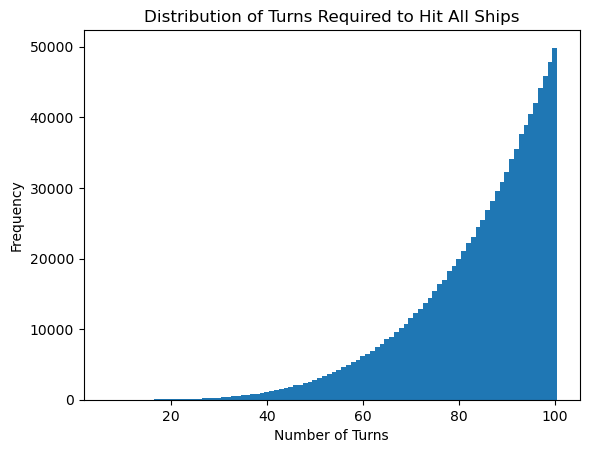

<Figure size 640x480 with 0 Axes>

In [ ]:
### Monte Carlo simulation of SBS games ###
# Calculates the distribution of turns needed to complete games

num_games = 1000000
turns_required = []

for _ in range(num_games):
    tiles_remaining = list(range(100))
    ships = random.sample(tiles_remaining, 5)
    turns = 0

    while ships:
        turns += 1
        shot = random.choice(tiles_remaining)
        tiles_remaining.remove(shot)
        if shot in ships:
            ships.remove(shot)

    turns_required.append(turns)

mean_turns = statistics.mean(turns_required)
median_turns = statistics.median(turns_required)
std_dev_turns = statistics.stdev(turns_required)

confidence_level = 0.95
t_value = t.ppf((1 + confidence_level) / 2, num_games - 1)
margin_error = t_value * std_dev_turns / math.sqrt(num_games)
confidence_interval = (mean_turns - margin_error, mean_turns + margin_error)

print("Mean turns:", mean_turns)
print("Median turns:", median_turns)
print("Standard deviation of turns:", std_dev_turns)
print("95% Confidence Interval:", confidence_interval)

# Plotting the distribution
plt.hist(turns_required, bins=range(min(turns_required), max(turns_required) + 2), align='left')
plt.xlabel("Number of Turns")
plt.ylabel("Frequency")
plt.title("Distribution of Turns Required to Hit All Ships")
plt.show()

#Save the figure
plt.savefig("Distribution of Turns Required to Hit All Ships.png")